In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default

# Common modules

In [3]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

# 0 Input is Image

label: 0


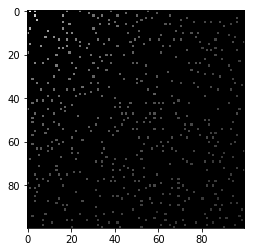

In [65]:
# when the input is an image
class SensorInputDatasetImage(Dataset):
    '''Sensor reading input dataset'''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))

    def __len__(self):
        return self.length * Default.sample_per_label

    def __getitem__(self, idx):
        folder   = self.oneDint2twoDstr(int(idx/Default.sample_per_label))
        imgname  = str(idx%Default.sample_per_label) + '.png'
        img_path = os.path.join(self.root_dir, folder, imgname)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.twoDstr2oneDint(folder)
        sample = {'image':image, 'label':label}
        return sample

    def oneDint2twoDstr(self, oneDint):
        '''convert a one dimension integer index to a two dimension string index'''
        x = oneDint // Default.grid_length
        y = oneDint % Default.grid_length
        return f'({x}, {y})'
    
    def twoDstr2oneDint(self, twoDstr):
        '''convert a two dimension string to a one dimension integet index for the labels'''
        twoDstr = twoDstr[1:-1]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        return x*Default.grid_length + y

root_dir = './data/images_1'
tf = T.Compose([
     T.ToTensor()
])

sensor_input_dataset = SensorInputDatasetImage(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=4, shuffle=True, num_workers=4)
plt.imshow(np.transpose(sensor_input_dataset[0]['image'], (1, 2, 0))[:, :, 0], cmap='gray')
print('label:', sensor_input_dataset[0]['label'])

---

# 2 Input is matrix, classification with 10K labels (area is 100x100)

In [4]:
# when the input is a matrix
class SensorInputDataset(Dataset):
    '''Sensor reading input dataset'''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))

    def __len__(self):
        return self.length * Default.sample_per_label

    def __getitem__(self, idx):
        folder   = self.oneDint2twoDstr(int(idx/Default.sample_per_label))
        matrix_name = str(idx%Default.sample_per_label) + '.txt'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.loadtxt(matrix_path, delimiter=',', dtype=float)
        if self.transform:
            matrix = self.transform(matrix)
        label = self.twoDstr2oneDint(folder)
        sample = {'matrix':matrix, 'label':label}
        return sample

    def oneDint2twoDstr(self, oneDint):
        '''convert a one dimension integer index to a two dimension string index'''
        x = oneDint // Default.grid_length
        y = oneDint % Default.grid_length
        return f'({x}, {y})'

    def twoDstr2oneDint(self, twoDstr):
        '''convert a two dimension string to a one dimension integet index for the labels'''
        twoDstr = twoDstr[1:-1]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        return x*Default.grid_length + y

In [5]:
class Net1(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 32, 5)
        self.fc    = nn.Linear(15488, 10000)  # too many labels

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
# data

root_dir = './data/matrix-1'
tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

sensor_input_dataset = SensorInputDataset(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=4, shuffle=True, num_workers=4)

In [7]:
# training

net1      = Net1()
device    = torch.device('cuda')
model     = net1.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # criterion is the loss function

num_epochs = 3
train_losses = []
valid_accs = []
best_acc = 0
print_every = 200

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

epoch = 0
t = 0, loss = 9.200733184814453
t = 200, loss = 9.21034049987793
t = 400, loss = 9.21034049987793
t = 600, loss = 9.21034049987793
t = 800, loss = 9.21034049987793
t = 1000, loss = 9.21034049987793
t = 1200, loss = 9.21034049987793
t = 1400, loss = 9.21034049987793
t = 1600, loss = 9.21034049987793
t = 1800, loss = 9.21034049987793
t = 2000, loss = 9.21034049987793
t = 2200, loss = 9.21034049987793
t = 2400, loss = 9.21034049987793
t = 2600, loss = 9.21034049987793
t = 2800, loss = 9.21034049987793
t = 3000, loss = 9.21034049987793
t = 3200, loss = 9.21034049987793
t = 3400, loss = 9.21034049987793
t = 3600, loss = 9.21034049987793
t = 3800, loss = 9.21034049987793
t = 4000, loss = 9.21034049987793
t = 4200, loss = 9.21034049987793
t = 4400, loss = 9.21034049987793
t = 4600, loss = 9.21034049987793
t = 4800, loss = 9.21034049987793
epoch = 1
t = 0, loss = 9.21034049987793
t = 200, loss = 9.21034049987793
t = 400, loss = 9.21034049987793
t = 600, loss = 9.21034049987793
t = 80

# 3 Output is image, model as image segmentation problem

## In the output grid (image), the location with the TX is 1, all others are 0

## 3.1 Loss is nn.BCEWithLogitsLoss()

In [10]:
class SensorInputDatasetSegmentation(Dataset):
    '''Sensor reading input dataset
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))

    def __len__(self):
        return self.length * Default.sample_per_label

    def __getitem__(self, idx):
        folder   = self.oneDint2twoDstr(int(idx/Default.sample_per_label))
        matrix_name = str(idx%Default.sample_per_label) + '.txt'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        matrix = np.loadtxt(matrix_path, delimiter=',', dtype=float)
        if self.transform:
            matrix = self.transform(matrix)
        label = self.twoDstr2twoDmatrix(folder)
        sample = {'matrix':matrix, 'label':label}
        return sample

    def oneDint2twoDstr(self, oneDint):
        '''convert a one dimension integer index to a two dimension string index'''
        x = oneDint // Default.grid_length
        y = oneDint % Default.grid_length
        return f'({x}, {y})'

    def twoDstr2twoDmatrix(self, twoDstr):
        '''convert a two dimension string to a one dimension integet index for the labels'''
        twoDstr = twoDstr[1:-1]
        x, y = twoDstr.split(',')
        x, y = int(x), int(y)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        grid[x][y] = 1
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32)


root_dir = './data/matrix-1'
tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

sensor_input_dataset = SensorInputDatasetSegmentation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=4, shuffle=True, num_workers=4)
print(sensor_input_dataset[0]['matrix'].shape)
print(sensor_input_dataset[0]['label'])

torch.Size([1, 100, 100])
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [11]:
# model

class Net2(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, 5, padding=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

net2 = Net2()
print(net2)

Net2(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [22]:
# training segmentation problem

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # criterion is the loss function

num_epochs = 2
train_losses = []
valid_accs = []
best_acc = 0
print_every = 200

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

epoch = 0
t = 0, loss = 0.6931371092796326
t = 200, loss = 0.001581347780302167
t = 400, loss = 0.001181990490294993
t = 600, loss = 0.0007860077894292772
t = 800, loss = 0.0007259153062477708
t = 1000, loss = 0.0006027893978171051
t = 1200, loss = 0.0005413669277913868
t = 1400, loss = 0.0005892982590012252
t = 1600, loss = 0.0006833101506344974
t = 1800, loss = 0.000665325962472707
t = 2000, loss = 0.0007167771691456437
t = 2200, loss = 0.0004928629496134818
t = 2400, loss = 0.0006421110010705888
t = 2600, loss = 0.0005880426033399999
t = 2800, loss = 0.0005871389294043183
t = 3000, loss = 0.0006019043503329158
t = 3200, loss = 0.0004949279245920479
t = 3400, loss = 0.000523646071087569
t = 3600, loss = 0.0004494731838349253
t = 3800, loss = 0.0004750811494886875
t = 4000, loss = 0.0004550309095066041
t = 4200, loss = 0.0004261813883204013
t = 4400, loss = 0.0007091080187819898
t = 4600, loss = 0.0006295934435911477
t = 4800, loss = 0.0005709975957870483
epoch = 1
t = 0, loss = 0.000

epoch = 0
(4, 1, 100, 100)


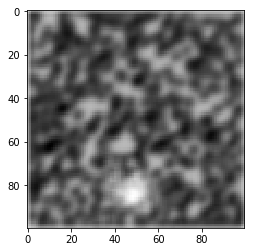

In [23]:
model.eval()
num_epochs = 1
train_losses = []
valid_accs = []
best_acc = 0
print_every = 100

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        break

pred = pred.data.cpu().numpy()
print(pred.shape)
i = 0
plt.imshow(pred[i, 0], cmap='gray')

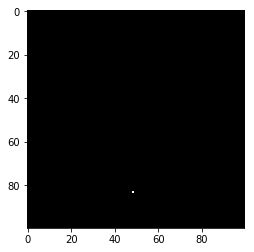

In [24]:
plt.imshow(y[i, 0].data.cpu(), cmap='gray')

## 3.2 Loss is nn.MSELoss()

In [16]:
# segmentation problem

net2 = Net2()

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

In [17]:
num_epochs = 2
train_losses = []
valid_accs = []
best_acc = 0
PATH = '/best_model_{}.pt'
print_every = 200

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

epoch = 0
t = 0, loss = 0.00019204223644919693
t = 200, loss = 0.00010304069292033091
t = 400, loss = 9.939263691194355e-05
t = 600, loss = 9.955420682672411e-05
t = 800, loss = 9.916906128637493e-05
t = 1000, loss = 9.881371079245582e-05
t = 1200, loss = 9.829936607275158e-05
t = 1400, loss = 9.838287951424718e-05
t = 1600, loss = 9.884424071060494e-05
t = 1800, loss = 0.00010008928802562878
t = 2000, loss = 0.00010058383486466482
t = 2200, loss = 9.985765063902363e-05
t = 2400, loss = 9.817850514082238e-05
t = 2600, loss = 9.743819100549445e-05
t = 2800, loss = 9.771838085725904e-05
t = 3000, loss = 9.725701238494366e-05
t = 3200, loss = 9.832384967012331e-05
t = 3400, loss = 0.0001036451430991292
t = 3600, loss = 9.761723049450666e-05
t = 3800, loss = 9.928594226948917e-05
t = 4000, loss = 9.62950216489844e-05
t = 4200, loss = 9.740480163600296e-05
t = 4400, loss = 9.809737821342424e-05
t = 4600, loss = 9.650543506722897e-05
t = 4800, loss = 9.844508167589083e-05
epoch = 1
t = 0, lo

epoch = 0
(4, 1, 100, 100)


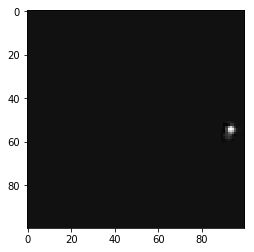

In [20]:
model.eval()
num_epochs = 1
train_losses = []
valid_accs = []
best_acc = 0
print_every = 100

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    for t, sample in enumerate(sensor_input_dataloader):
        model.train()
        X = sample['matrix'].to(device)
        y = sample['label'].to(device)
        pred = model(X)
        break

pred = pred.data.cpu().numpy()
print(pred.shape)
i = 0
plt.imshow(pred[i, 0], cmap='gray')

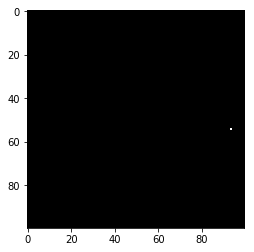

In [21]:
plt.imshow(y[i, 0].data.cpu(), cmap='gray')

# Mics

In [30]:
a = np.loadtxt('data/matrix-1/(0, 0)/0.txt', dtype=float, delimiter=',')

In [37]:
a.shape, type(a)

((100, 100), numpy.ndarray)

In [34]:
b = imageio.imread('data/images_1/(0, 0)/0.png')

In [36]:
b.shape, type(b)

((100, 100), imageio.core.util.Array)

In [24]:
a = np.array([1.1, 2.2, 3.3])

In [26]:
a.astype(np.float32)

array([1.1, 2.2, 3.3], dtype=float32)